<a href="https://colab.research.google.com/github/fantaxiah/MachineLearningFall23/blob/main/CaseStudy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [2]:
# Import my file
csv_file_path = '/content/ClassifyRisk_Dataset(1).csv'
# Read the CSV file into a dataframe
df= pd.read_csv(csv_file_path)

df

,Age,Maritial,Mortgage,Loan Type,Income,Risk
0,44.0,other,y,3.0,36060.70,bad loss
1,41.0,other,n,2.0,36009.34,bad loss
2,46.0,other,n,2.0,35614.60,bad loss
3,42.0,other,y,2.0,35287.18,bad loss
4,36.0,other,y,2.0,34954.06,bad loss
...,...,...,...,...,...,...
241,24.0,single,y,0.0,34810.12,good risk
242,16.0,single,y,0.0,33709.78,good risk
243,21.0,single,y,0.0,32896.42,good risk
244,23.0,single,y,0.0,32301.52,good risk


1. Perform the data cleaning as needed (remove any missing data, retain the observations with valid categories or range). If you remove any data, please clearly mention it.

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Drop rows with missing values
df_cleaned = df.dropna()

Missing Values:
 Age          1
Maritial     0
Mortgage     0
Loan Type    1
Income       2
Risk         0
dtype: int64


In [4]:
# Checking unique values in columns
print("Unique Age Categories:", df_cleaned['Age'].unique())
print("Unique Mortgage Categories:", df_cleaned['Mortgage'].unique())
print("Unique Loan Type Categories:", df_cleaned['Loan Type'].unique())
print("Unique Risk Categories:", df_cleaned['Risk'].unique())

# Identify the row with the weird value in 'Mortgage
weird_row_index = df[df['Mortgage'] == '"'].index

# Drop the row with the weird value
df = df.drop(weird_row_index, inplace=True) #NOT WORKING

df_cleaned

Unique Age Categories: [44. 41. 46. 42. 36. 40. 39. 51. 47. 30. 33. 29. 43. 50. 48. 45. 49. 31.
 37. 28. 27. 32. 35. 38. 34. 26. 21. 25. 23. 20. 19. 22. 17. 24. 16. 18.
 11. 13.]
Unique Mortgage Categories: ['y' 'n' '"']
Unique Loan Type Categories: [3. 2. 1. 0.]
Unique Risk Categories: ['bad loss' 'good risk']


,Age,Maritial,Mortgage,Loan Type,Income,Risk
0,44.0,other,y,3.0,36060.70,bad loss
1,41.0,other,n,2.0,36009.34,bad loss
2,46.0,other,n,2.0,35614.60,bad loss
3,42.0,other,y,2.0,35287.18,bad loss
4,36.0,other,y,2.0,34954.06,bad loss
...,...,...,...,...,...,...
241,24.0,single,y,0.0,34810.12,good risk
242,16.0,single,y,0.0,33709.78,good risk
243,21.0,single,y,0.0,32896.42,good risk
244,23.0,single,y,0.0,32301.52,good risk


2. Perform exploratory data analysis. Comment on your finding about the most relevant predictor variables which is associated with the response variable ”Risk”.

In [5]:
# Descriptive statistics
print(df_cleaned.describe())

              Age   Loan Type        Income
count  244.000000  244.000000    244.000000
mean    31.979508    1.303279  36842.341803
std      9.620130    0.845120   8937.676038
min     11.000000    0.000000  22191.750000
25%     23.000000    1.000000  30529.525000
50%     33.000000    1.000000  35299.240000
75%     40.000000    2.000000  41714.312500
max     51.000000    3.000000  66398.620000


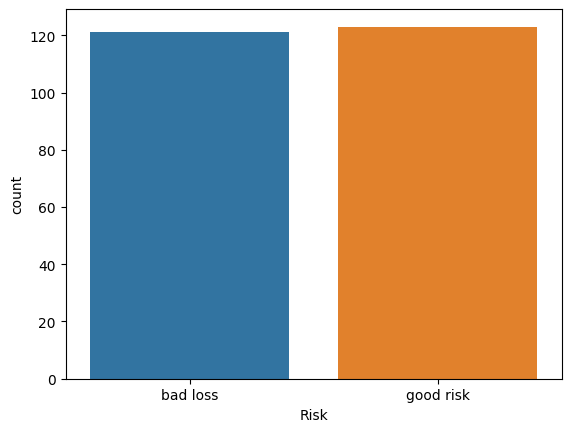

In [6]:
# Distribution of the target variable
sns.countplot(x='Risk', data=df_cleaned)
plt.show()

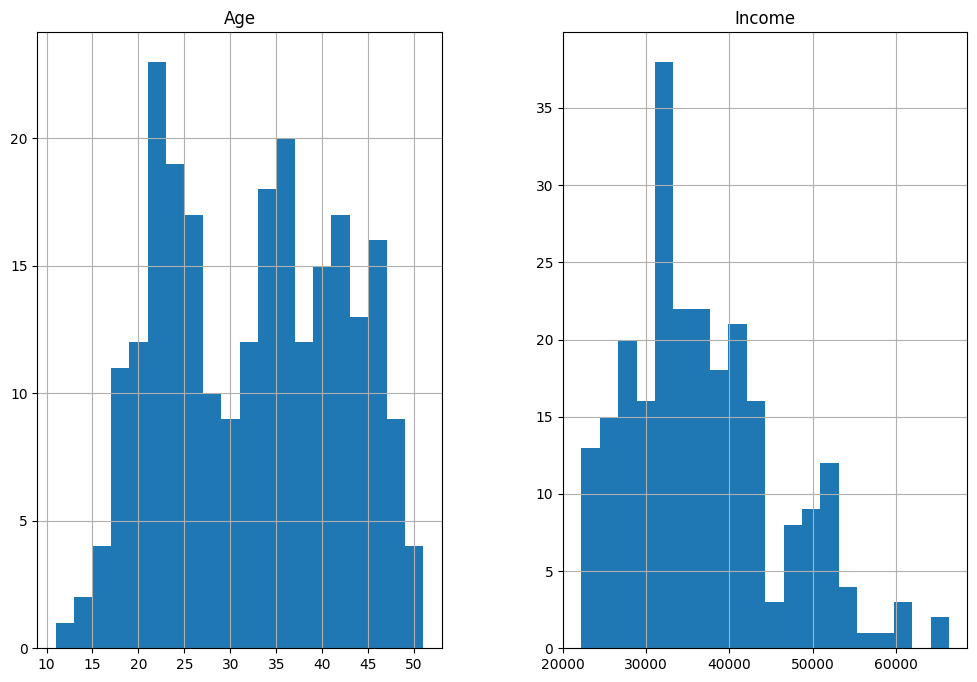

In [7]:
# Distribution of numerical features
num_features = ['Age', 'Income', 'Mortgage']
df_cleaned[num_features].hist(bins=20, figsize=(12, 8))
plt.show()

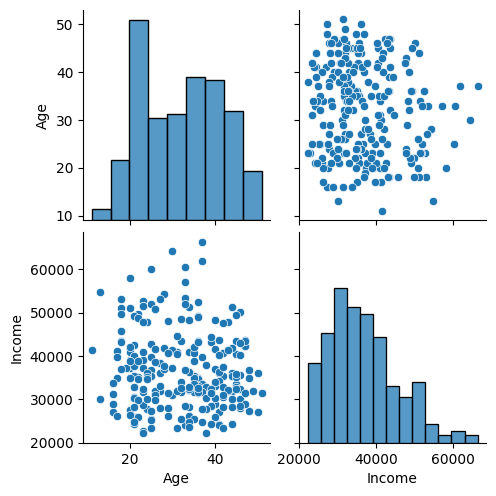

In [8]:
# Pairwise scatter plots for numerical features
sns.pairplot(df_cleaned[num_features])
plt.show()

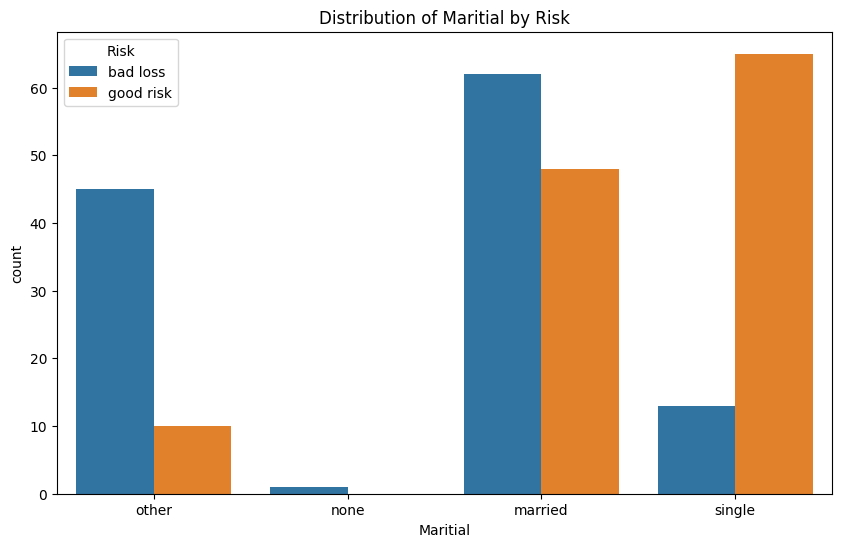

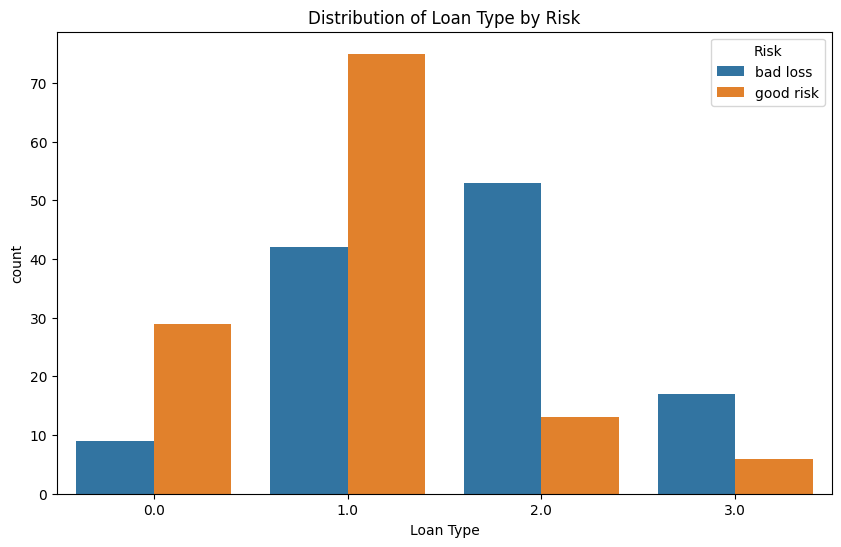

In [9]:
# Categorical feature analysis
cat_features = ['Maritial', 'Loan Type']
for feature in cat_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Risk', data=df_cleaned)
    plt.title(f'Distribution of {feature} by Risk')
    plt.show()

<ipython-input-10-fa6b77a3557b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned.corr()


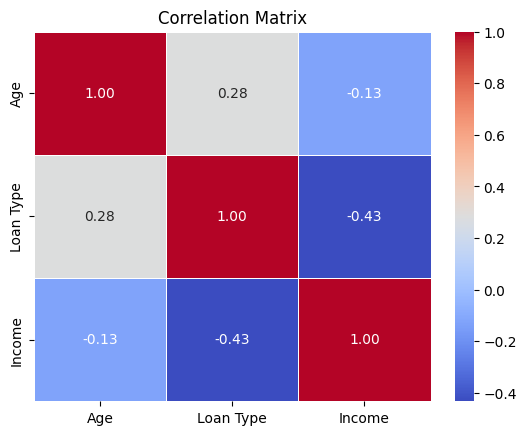

In [10]:
# Correlation matrix
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<ipython-input-11-80e315a5153c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Age'] = pd.to_numeric(df_cleaned['Age'], errors='coerce')


Non-numeric values in 'Age': Series([], Name: Age, dtype: float64)


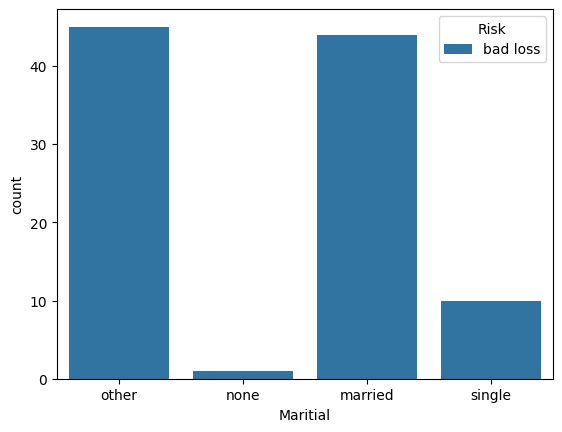

In [11]:
# Converting Age to numeric
df_cleaned['Age'] = pd.to_numeric(df_cleaned['Age'], errors='coerce')

# Checking for non-numeric values in Age
non_numeric_age = df_cleaned[~df_cleaned['Age'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
print("Non-numeric values in 'Age':", non_numeric_age['Age'])

# Subset data
subset_data = df_cleaned.head(100)  # Adjusting number of rows here
sns.countplot(x='Maritial', hue='Risk', data=subset_data)
plt.show()

In [12]:
# Convert string columns to numeric values
df_cleaned['Risk'] = df_cleaned['Risk'].replace('bad loss', 0)
df_cleaned['Risk'] = df_cleaned['Risk'].replace('good risk', 1)
df_cleaned['Risk'] = pd.to_numeric(df_cleaned['Risk'], errors='coerce')

df_cleaned['Maritial'] = df_cleaned['Maritial'].replace('other', 0)
df_cleaned['Maritial'] = df_cleaned['Maritial'].replace('none', 1)
df_cleaned['Maritial'] = df_cleaned['Maritial'].replace('married', 2)
df_cleaned['Maritial'] = df_cleaned['Maritial'].replace('single', 3)
df_cleaned['Maritial'] = pd.to_numeric(df_cleaned['Maritial'], errors='coerce')

df_cleaned['Mortgage'] = df_cleaned['Mortgage'].replace('n', 0)
df_cleaned['Mortgage'] = df_cleaned['Mortgage'].replace('y', 1)
df_cleaned['Mortgage'] = pd.to_numeric(df_cleaned['Mortgage'], errors='coerce')

df_cleaned.dropna(inplace=True)

df_cleaned

<ipython-input-12-f616bfa62df9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Risk'] = df_cleaned['Risk'].replace('bad loss', 0)
<ipython-input-12-f616bfa62df9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Risk'] = df_cleaned['Risk'].replace('good risk', 1)
<ipython-input-12-f616bfa62df9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,Age,Maritial,Mortgage,Loan Type,Income,Risk
0,44.0,0,1.0,3.0,36060.70,0
1,41.0,0,0.0,2.0,36009.34,0
2,46.0,0,0.0,2.0,35614.60,0
3,42.0,0,1.0,2.0,35287.18,0
4,36.0,0,1.0,2.0,34954.06,0
...,...,...,...,...,...,...
241,24.0,3,1.0,0.0,34810.12,1
242,16.0,3,1.0,0.0,33709.78,1
243,21.0,3,1.0,0.0,32896.42,1
244,23.0,3,1.0,0.0,32301.52,1


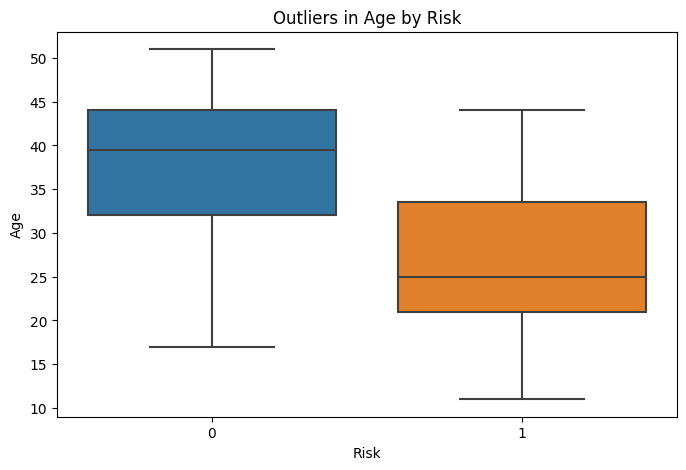

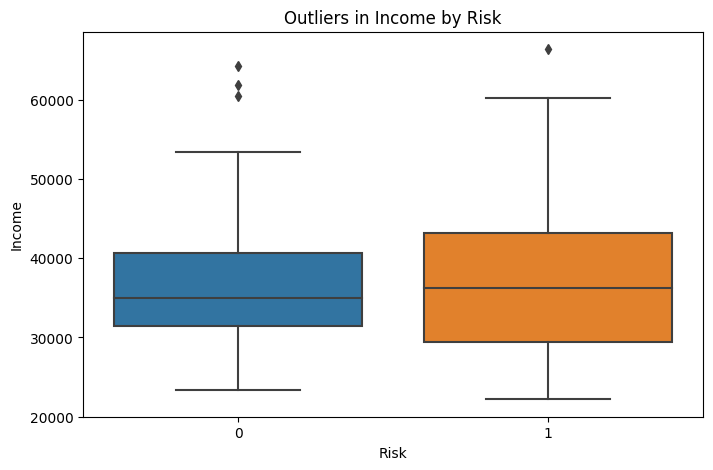

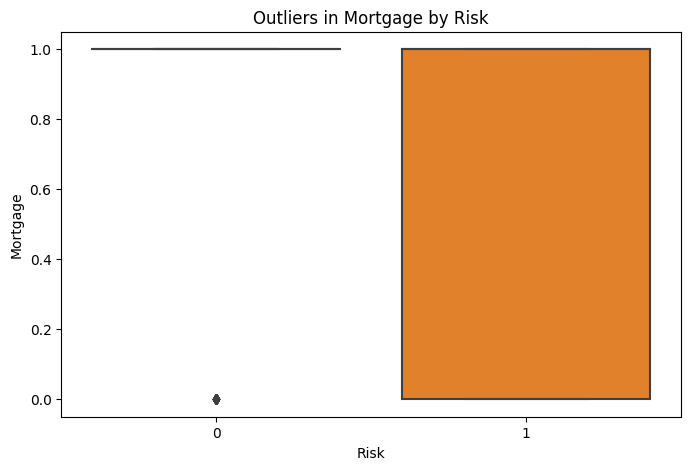

In [13]:
# Box plots for outlier detection
for feature in num_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Risk', y=feature, data=df_cleaned)
    plt.title(f'Outliers in {feature} by Risk')
    plt.show()

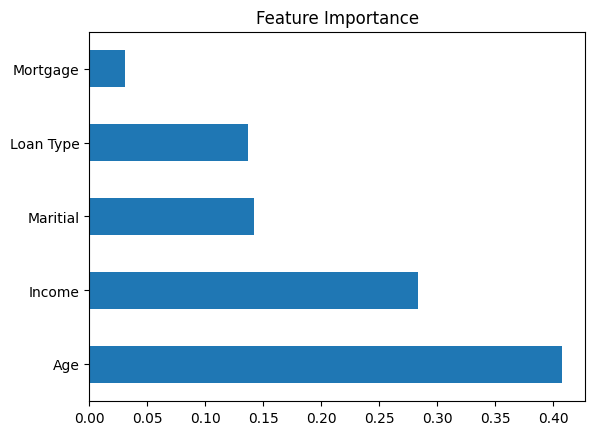

In [14]:
# Example using a random forest for feature importance
X = df_cleaned.drop('Risk', axis=1)
y = df_cleaned['Risk']

model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

In [15]:
correlation_matrix = df_cleaned.corr()
correlation_with_target = correlation_matrix['Risk'].sort_values(ascending=False)
print(correlation_with_target)

Risk         1.000000
Maritial     0.456464
Income       0.063595
Mortgage    -0.129132
Loan Type   -0.399401
Age         -0.577173
Name: Risk, dtype: float64


In [16]:
# Example for numerical variable
for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    stat, p_value = ttest_ind(df_cleaned[df_cleaned['Risk'] == 0][column], df_cleaned[df_cleaned['Risk'] == 1][column])
    print(f'T-test for {column}: p-value = {p_value}')

# Example for categorical variable
for column in df_cleaned.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(df_cleaned[column], df_cleaned['Risk'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f'Chi-square test for {column}: p-value = {p}')


T-test for Age: p-value = 5.53035229077301e-23
T-test for Maritial: p-value = 6.56387816908825e-14
T-test for Mortgage: p-value = 0.04432385413658085
T-test for Loan Type: p-value = 1.0129140247354719e-10
T-test for Income: p-value = 0.3235293522357351
T-test for Risk: p-value = 0.0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [17]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=1)
fit = rfe.fit(X, y)

selected_features = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
selected_features.sort_values(by='Ranking', inplace=True)
print(selected_features)

     Feature  Ranking
1   Maritial        1
2   Mortgage        2
3  Loan Type        3
0        Age        4
4     Income        5


In [18]:
mutual_info = pd.Series(mutual_info_classif(X, y), index=X.columns)
mutual_info.sort_values(ascending=False, inplace=True)
print(mutual_info)

Age          0.171900
Loan Type    0.104331
Maritial     0.102103
Mortgage     0.010378
Income       0.000000
dtype: float64


3. Create 80:20% train:test data split.

In [19]:
X = df_cleaned.drop('Risk', axis=1)
y = df_cleaned['Risk']

# Set the seed
np.random.seed(42)

# Perform the 80:20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print("Number of rows in Training Data:", X_train.shape[0])
print("Number of rows in Testing Data:", X_test.shape[0])

Number of rows in Training Data: 194
Number of rows in Testing Data: 49


4. Create k-nearest neighbour classification model with different number of nearest neighbours (try at least 5 different nearest neighbours). Evaluate the model performance using testing data. Use appropriate evaluation metrics (eg: accuracy, sensitivity, area under the ROC curve, etc).

In [20]:
def train_and_evaluate_knn(X_train, X_test, y_train, y_test, k):
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # Train the model
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print(f'KNN with k={k} - Accuracy: {accuracy:.4f}')

# Try different values of k
k_values = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Train and evaluate the KNN model for each k value
for k in k_values:
    train_and_evaluate_knn(X_train, X_test, y_train, y_test, k)

KNN with k=5 - Accuracy: 0.5306
KNN with k=6 - Accuracy: 0.5102
KNN with k=7 - Accuracy: 0.5102
KNN with k=8 - Accuracy: 0.5306
KNN with k=9 - Accuracy: 0.5306
KNN with k=10 - Accuracy: 0.5918
KNN with k=11 - Accuracy: 0.6122
KNN with k=12 - Accuracy: 0.5918
KNN with k=13 - Accuracy: 0.5918
KNN with k=14 - Accuracy: 0.5510
KNN with k=15 - Accuracy: 0.5510
KNN with k=16 - Accuracy: 0.5918
KNN with k=17 - Accuracy: 0.6327
KNN with k=18 - Accuracy: 0.6122
KNN with k=19 - Accuracy: 0.5918
KNN with k=20 - Accuracy: 0.5918


Accuracy: 0.6327
Precision: 0.6087
Recall: 0.6087
F1 Score: 0.6087
ROC AUC Score: 0.6003
Confusion Matrix:
[[17  9]
 [ 9 14]]


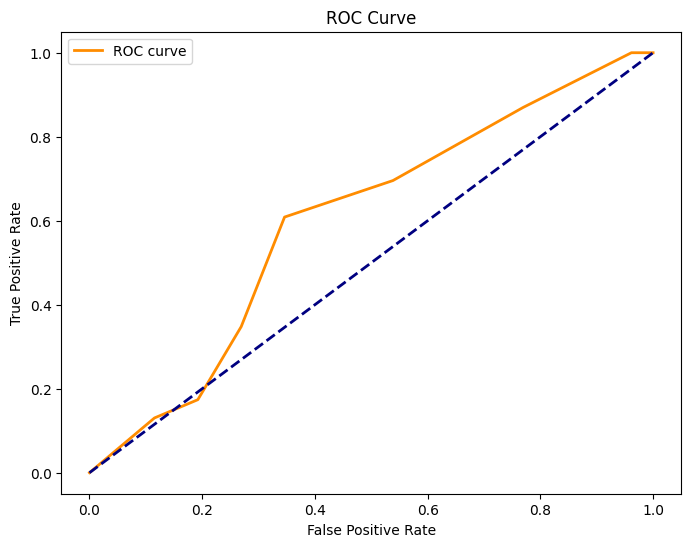

In [21]:
# Define and train the KNN model
best_k = 17  # best k value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Display the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

5. Build a simple neural network model with one hidden layer (try different number of hidden nodes) to build an effective classification model by using training data. Evaluate the model performance using testing data (use the same evaluation metrics that you had used).

2/2 [==============================] - 0s 19ms/step
Model with 10 hidden nodes:
Accuracy: 0.8163
Confusion Matrix:
[[19  7]
 [ 2 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81        26
           1       0.75      0.91      0.82        23

    accuracy                           0.82        49
   macro avg       0.83      0.82      0.82        49
weighted avg       0.83      0.82      0.82        49



2/2 [==============================] - 0s 12ms/step
Model with 20 hidden nodes:
Accuracy: 0.8163
Confusion Matrix:
[[20  6]
 [ 3 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        26
           1       0.77      0.87      0.82        23

    accuracy                           0.82        49
   macro avg       0.82      0.82      0.82        49
weighted avg       0.82      0.82      0.82        49

2/2 [==============================] - 0s 7ms/step
Model with 30 hidden nodes:
Accuracy: 0.7755
Confusion Matrix:
[[18  8]
 [ 3 20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77        26
           1       0.71      0.87      0.78        23

    accuracy                           0.78        49
   macro avg       0.79      0.78      0.78        49
weighted avg       0.79      0.78      0.77        49

2/2 [============================

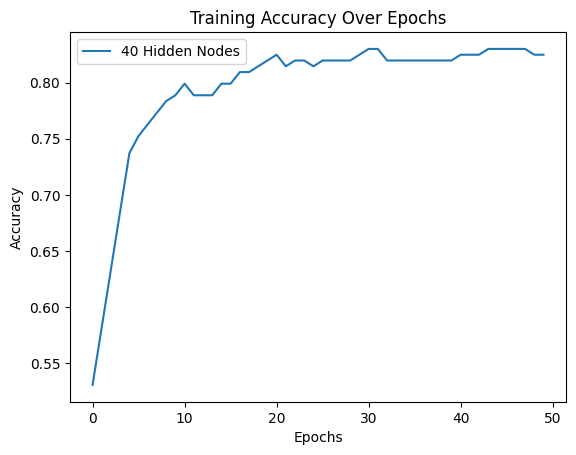

In [23]:
# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a neural network with one hidden layer
def build_model(hidden_nodes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_nodes, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model with different numbers of hidden nodes
hidden_nodes_values = [10, 20, 30, 40]  # Try different numbers of hidden nodes
models = []

for nodes in hidden_nodes_values:
    model = build_model(nodes)
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
    models.append((model, nodes, history))

# Evaluate and compare models on the test set
for model, nodes, history in models:
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Model with {nodes} hidden nodes:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

# Plot the training history
plt.plot(history.history['accuracy'], label=f'{nodes} Hidden Nodes')

plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Build a deep neural network model with three or four hidden layers (try different number of hidden nodes within each layer) to build an effective classification model by using training data. Evaluate the model performance using testing data (use the same evaluation metrics that you had used).

2/2 [==============================] - 0s 7ms/step
Deep Model with 32-16-8 hidden nodes in layers 1-2-3:
Accuracy: 0.7755
Confusion Matrix:
[[19  7]
 [ 4 19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        26
           1       0.73      0.83      0.78        23

    accuracy                           0.78        49
   macro avg       0.78      0.78      0.78        49
weighted avg       0.78      0.78      0.78        49

2/2 [==============================] - 0s 8ms/step
Deep Model with 32-16-16 hidden nodes in layers 1-2-3:
Accuracy: 0.7959
Confusion Matrix:
[[18  8]
 [ 2 21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        26
           1       0.72      0.91      0.81        23

    accuracy                           0.80        49
   macro avg       0.81      0.80      0.80        49
weighted avg       0.82      0.80   

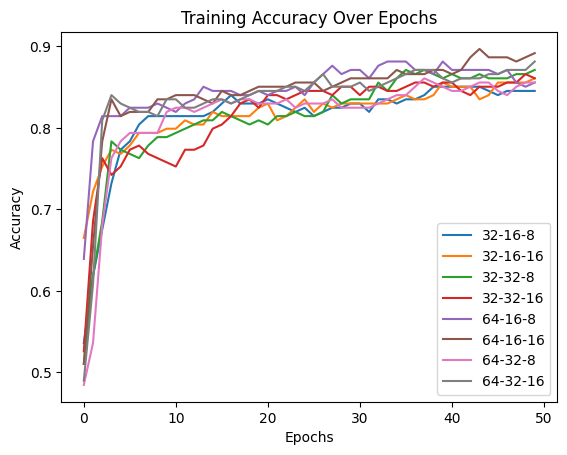

In [24]:
# Build a deep neural network with three hidden layers
def build_deep_model(hidden_nodes_layer1, hidden_nodes_layer2, hidden_nodes_layer3):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_nodes_layer1, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(hidden_nodes_layer2, activation='relu'),
        tf.keras.layers.Dense(hidden_nodes_layer3, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the deep model with different numbers of hidden nodes in each layer
hidden_nodes_values_layer1 = [32, 64]  # Try different numbers of hidden nodes in the first layer
hidden_nodes_values_layer2 = [16, 32]  # Try different numbers of hidden nodes in the second layer
hidden_nodes_values_layer3 = [8, 16]   # Try different numbers of hidden nodes in the third layer

deep_models = []

for nodes1 in hidden_nodes_values_layer1:
    for nodes2 in hidden_nodes_values_layer2:
        for nodes3 in hidden_nodes_values_layer3:
            model = build_deep_model(nodes1, nodes2, nodes3)
            history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
            deep_models.append((model, nodes1, nodes2, nodes3, history))

# Evaluate and compare deep models on the test set
for model, nodes1, nodes2, nodes3, history in deep_models:
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Deep Model with {nodes1}-{nodes2}-{nodes3} hidden nodes in layers 1-2-3:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    # Plot the training history
    plt.plot(history.history['accuracy'], label=f'{nodes1}-{nodes2}-{nodes3}')

plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
